# Model Baseline - Arima

Test performance of stock prediction based on conventional forecasting models

In [5]:
import datetime
import importlib
import numpy as N
import numpy.random as NR
import matplotlib.pyplot as pyplot
import seaborn
import pandas as P
from pathlib import Path
import pyspark.mllib as SM
import pyspark.mllib.feature as SMF
import itertools
import warnings
import statsmodels.api as Sm
import statsmodels
import tqdm

seaborn.set_style('whitegrid')

In [2]:
pathStocks = Path('datasets/Stocks')
pathARIMA = Path('models/arima')
stocks = P.read_csv(pathStocks / 'stocks.csv')
startTrain = datetime.datetime(2017, 1, 1)
endTrain = datetime.datetime(2019, 1, 1)
startTest = endTrain
endTest = datetime.datetime(2019, 7, 1)

In [11]:
def train_arima_model(series, verbose=False):
    """
    series: A training set (i.e. 2017-01-01 to 2018-12-31)
    """
    series = series[series.index.map(lambda x:startTrain <= x and x <= endTrain)]
    # Define the p, d and q parameters to take any value between 0 and 3
    
    # Perform Hyperparameter search
    p = d = q = range(0, 3)
    # Generate all different combinations of p, q and q
    pdq = list(itertools.product(p, d, q))
    
    warnings.filterwarnings("ignore")
    aic = []
    parameters = []
    for param in pdq:
        #for param in pdq:
#         try:
        mod = sm.tsa.statespace.SARIMAX(series, order=param, enforce_stationarity=True, enforce_invertibility=True)
        results = mod.fit()
        # save results in lists
        aic.append(results.aic)
        parameters.append(param)
        #seasonal_param.append(param_seasonal)
        if verbose:
            print('ARIMA{} - AIC:{}'.format(param, results.aic))
#         except:
#             continue
    # find lowest aic          
    index_min = min(range(len(aic)), key=aic.__getitem__)           

    # print('The optimal model is: ARIMA{} -AIC{}'.format(parameters[index_min], aic[index_min]))
    
    return parameters[index_min]

def one_day_arima(series, endDate, params):
    mask = series.index.map(lambda x:startTrain <= x and x < endDate)
    model = statsmodels.tsa.arima_model.ARIMA(series[mask], order=params)
    model = model.fit(disp=0)
    yhat,_,_ = model.forecast(steps=1)
    return yhat[0]

def evaluate_arima_model(series, params):
    """
    series: Train set and test set combined
    
    What this function should do: For each date d within [2019-01-01, 2019-08-31], train the ARIMA model
    with data **ONLY** from [2017-01-01, d) and forecast the next date (i.e. .forecast(1)). Store the result in another df series.
    
    Ideally, do something like this:
    
    train_mask = df.index.map(lambda x:x.year == 2017 or x.year == 2018)
    params = train_arima_model(df['Y'][train_mask])
    df['Yhat'] = evaluate_arima_model(df['Y'], params)
    
    Then, save the resulting df to `models/arima/AAPL.csv` for further evaluation downstream.
    Run this on a single csv first to make sure it works. A df is provided above.
    """
    
    # Find set of index which needs prediction
    testIndex = series.index[series.index.map(lambda x:startTest <= x and x <= endTest)]
    pred = {i: one_day_arima(series, i, params) for i in testIndex}
    return P.Series(pred)

def predict_stock(df):
    params = train_arima_model(df['X'])
    predicted = evaluate_arima_model(df['X'], params)
    df['Xhat'] = predicted
    df['Yhat'] = (df['Xhat'].shift(-1) - df['X']) / df['sigma_hat']
    return df

In [18]:
for ticker in tqdm.tqdm(stocks['Ticker'].to_list()):
    pIn = pathStocks /  (ticker+'.csv')
    pOut = pathARIMA / (ticker+'.csv')
    
    df = P.read_csv(pIn).set_index('Date')
    df.index = df.index.map(lambda x:P.to_datetime(x, format='%Y-%m-%d'))
    try:
        if not pOut.exists():
            df = predict_stock(df)
            testMask = df.index.map(lambda x:startTest <= x and x < endTest)
            df[testMask].reset_index()[['Date', 'Yhat', 'Xhat']].to_csv(pOut, index=False)
    except N.linalg.LinAlgError as e:
        print(f"Unable to process ticker {ticker}, {e}")
    except ValueError as e:
        print(f"Unable to process ticker {ticker}, {e}")

 81%|████████▏ | 26/32 [00:03<00:01,  3.26it/s]

Unable to process ticker PEP, LU decomposition error.


 88%|████████▊ | 28/32 [00:05<00:02,  1.58it/s]

Unable to process ticker LMT, The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


100%|██████████| 32/32 [02:28<00:00,  4.65s/it]


## Example Execution on AAPL

In [68]:
df = P.read_csv(pathStocks / 'AAPL.csv').set_index('Date')
df.index = df.index.map(lambda x:P.to_datetime(x, format='%Y-%m-%d'))

df = predict_stock(df)
df

100%|██████████| 124/124 [00:02<00:00, 45.32it/s]


,Open,High,Low,Close,Volume,Dividends,Stock Splits,S,X,sigma_hat,Y,Xhat,Yhat
Date,,,,,,,,,,,,,
2016-12-01,25.920214,26.054078,25.605517,25.713547,148347600,0.0,0,25.816881,25.849792,NaN,NaN,NaN,NaN
2016-12-02,25.638392,25.854452,25.563240,25.809832,106112000,0.0,0,25.724112,25.755846,NaN,NaN,NaN,NaN
2016-12-05,25.833317,25.840362,25.422332,25.624302,137298000,0.0,0,25.728809,25.757374,NaN,NaN,NaN,NaN
2016-12-06,25.715892,25.917862,25.643090,25.821573,104782000,0.0,0,25.768733,25.796281,NaN,NaN,NaN,NaN
2016-12-07,25.659532,26.112789,25.636047,26.075212,119994800,0.0,0,25.867372,25.893962,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-25,51.007379,51.092845,50.479943,50.550758,55638400,0.0,0,50.779069,50.496017,0.660953,-0.125788,NaN,NaN
2019-07-26,50.663080,51.212492,50.580059,50.726570,70475600,0.0,0,50.694825,50.412877,0.477774,0.704924,NaN,NaN
2019-07-29,50.902379,51.434697,50.897495,51.200279,86693600,0.0,0,51.051329,50.749671,0.605359,-0.119868,NaN,NaN


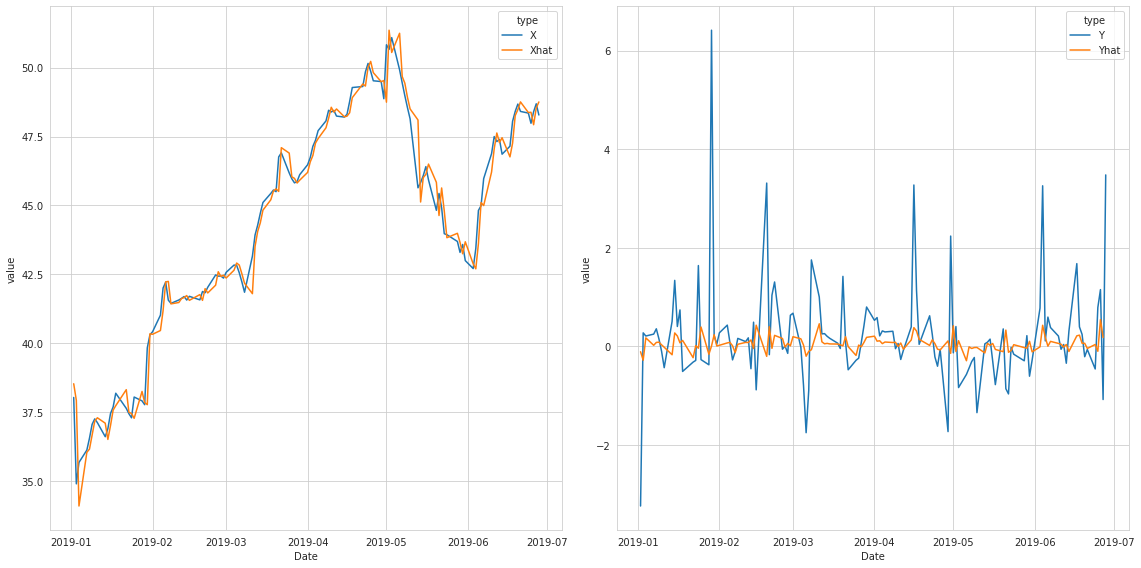

In [69]:
fig, axs = pyplot.subplots(1, 2, figsize=(16,8))
df_plot = df[df.index.map(lambda x:startTest <= x < endTest)].reset_index()
seaborn.lineplot(x='Date', y='value', hue='type', ax=axs[0],
                data=df_plot[['Date', 'X', 'Xhat']].melt(id_vars='Date', value_name='value', var_name='type'))
seaborn.lineplot(x='Date', y='value', hue='type', ax=axs[1],
                data=df_plot[['Date', 'Y', 'Yhat']].melt(id_vars='Date', value_name='value', var_name='type'))
fig.tight_layout()

## Legacy code

In [33]:
from datetime import timedelta, date
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [43]:
def predict_stock(symbol):
    file_name = symbol + '.csv'
    df = P.read_csv(pathStocks / file_name).set_index('Date')
    df = df[['Close']]
    
    train_mask = df.index.map(lambda x:x[:4] == '2017' or x[:4] == '2018')
    params = train_arima_model(df[train_mask])
    
    start_date = date(2019, 1, 1)
    end_date = date(2019, 7, 1)

    temp_df = df[train_mask].copy()
    for single_date in tqdm(list(daterange(start_date, end_date))):
        date_str = single_date.strftime("%Y-%m-%d")
        model = evaluate_arima_model(temp_df, params)
        next_close = model.forecast(steps=1)[0][0]
        temp_df = temp_df.append(P.DataFrame({'Close': next_close}, index = [date_str]))

    temp_df.to_csv(pathARIMA / file_name, header = True, index_label = 'Date')

In [44]:
predict_stock('AAPL')

ARIMA(0, 0, 0) - AIC:6452.857409309223
ARIMA(0, 0, 1) - AIC:5604.672882693521
ARIMA(0, 0, 2) - AIC:4835.799314189104
ARIMA(0, 1, 0) - AIC:1282.2147375746836
ARIMA(0, 1, 1) - AIC:1284.075519866524
ARIMA(0, 1, 2) - AIC:1285.281429784211
ARIMA(0, 2, 0) - AIC:1704.4389200941603
ARIMA(0, 2, 1) - AIC:1288.0459589757638
ARIMA(0, 2, 2) - AIC:1289.9206061984023
ARIMA(1, 0, 0) - AIC:1294.3521992144501
ARIMA(1, 0, 1) - AIC:1296.2115400713667
ARIMA(1, 0, 2) - AIC:1297.4209231113673
ARIMA(1, 1, 0) - AIC:1284.0858594944048
ARIMA(1, 1, 1) - AIC:1284.5602155831716
ARIMA(1, 1, 2) - AIC:1287.2722718690031
ARIMA(1, 2, 0) - AIC:1548.0938961754619
ARIMA(1, 2, 1) - AIC:1289.9438009504547
ARIMA(1, 2, 2) - AIC:1290.4004462784983
ARIMA(2, 0, 0) - AIC:1296.221958570299
ARIMA(2, 0, 1) - AIC:1296.6971978884462
ARIMA(2, 0, 2) - AIC:1299.2193530233371
ARIMA(2, 1, 0) - AIC:1285.2122688782056
ARIMA(2, 1, 1) - AIC:1287.1989782860264
ARIMA(2, 1, 2) - AIC:1276.4705701032533
ARIMA(2, 2, 0) - AIC:1472.922062638842
ARIMA(2

  0%|          | 0/181 [00:00<?, ?it/s]

ARIMA(2, 2, 2) - AIC:1292.2744853520444


100%|██████████| 181/181 [01:13<00:00,  2.47it/s]


In [1]:
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import itertools
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")

import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)

data = pdr.get_data_yahoo("MSFT", start="2020-01-01", end="2020-08-31")

[*********************100%***********************]  1 of 1 completed


In [2]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,158.779999,160.729996,158.330002,160.619995,158.936279,22622100
2020-01-03,158.320007,159.949997,158.059998,158.619995,156.957260,21116200
2020-01-06,157.080002,159.100006,156.509995,159.029999,157.362961,20813700
2020-01-07,159.320007,159.669998,157.320007,157.580002,155.928177,21634100
2020-01-08,158.929993,160.800003,157.949997,160.089996,158.411835,27746500


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 167 entries, 2020-01-02 to 2020-08-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       167 non-null    float64
 1   High       167 non-null    float64
 2   Low        167 non-null    float64
 3   Close      167 non-null    float64
 4   Adj Close  167 non-null    float64
 5   Volume     167 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 9.1 KB


<AxesSubplot:xlabel='Date'>

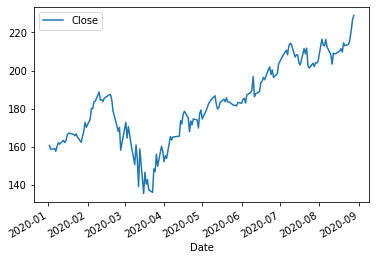

In [4]:
df = data[['Close']]

df.plot(style="-")

In [5]:
def arima(df):
    # Define the p, d and q parameters to take any value between 0 and 3
    p = d = q = range(0, 3)
    # Generate all different combinations of p, q and q
    pdq = list(itertools.product(p, d, q))
    
    warnings.filterwarnings("ignore")
    aic= []
    parameters = []
    for param in pdq:
        #for param in pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df, order=param,       
            enforce_stationarity=True, enforce_invertibility=True)

            results = mod.fit()
            # save results in lists
            aic.append(results.aic)
            parameters.append(param)
            #seasonal_param.append(param_seasonal)
            print('ARIMA{} - AIC:{}'.format(param, results.aic))
        except:
            continue
    # find lowest aic          
    index_min = min(range(len(aic)), key=aic.__getitem__)           

    print('The optimal model is: ARIMA{} -AIC{}'.format(parameters[index_min], aic[index_min]))
    
    model = ARIMA(df, order=parameters[index_min])
    model_fit = model.fit(disp=0)
    return model_fit

ARIMA(0, 0, 0) - AIC:2217.0343074553602
ARIMA(0, 0, 1) - AIC:1994.933591489852
ARIMA(0, 0, 2) - AIC:1853.2437803837458
ARIMA(0, 1, 0) - AIC:1014.1811469920146
ARIMA(0, 1, 1) - AIC:992.776514028533
ARIMA(0, 1, 2) - AIC:985.6772076304838
ARIMA(0, 2, 0) - AIC:1178.9828431191715
ARIMA(0, 2, 1) - AIC:1015.1164651670588
ARIMA(0, 2, 2) - AIC:993.0043746148124
ARIMA(1, 0, 0) - AIC:1029.5613920771477
ARIMA(1, 0, 1) - AIC:1008.1645051977601
ARIMA(1, 0, 2) - AIC:1001.0771001791026
ARIMA(1, 1, 0) - AIC:987.1508434930377
ARIMA(1, 1, 1) - AIC:989.1506116052183
ARIMA(1, 1, 2) - AIC:987.5993813909215
ARIMA(1, 2, 0) - AIC:1069.2867744330463
ARIMA(1, 2, 1) - AIC:987.4742976379662
ARIMA(1, 2, 2) - AIC:989.4699208495706
ARIMA(2, 0, 0) - AIC:1002.5431340859041
ARIMA(2, 0, 1) - AIC:1004.5429102197033
ARIMA(2, 0, 2) - AIC:1006.9147463133488
ARIMA(2, 1, 0) - AIC:989.1504299585871
ARIMA(2, 1, 1) - AIC:989.7974858892692
ARIMA(2, 1, 2) - AIC:989.3580310387098
ARIMA(2, 2, 0) - AIC:1022.5870409745814
ARIMA(2, 2, 1

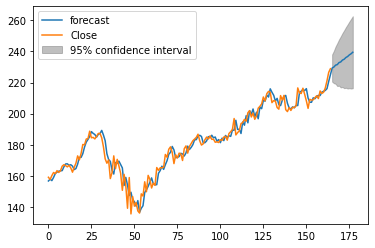

In [6]:
arima_result = arima(df)
print(arima_result.summary())
arima_result.plot_predict(start=2, end=len(df)+12)
plt.show()

In [7]:
arima_result.forecast(steps=10)

(array([229.34677948, 229.9882719 , 231.20873087, 231.56295938,
        232.85553489, 233.26880976, 234.47814421, 235.00808807,
        236.12479833, 236.75853747]),
 array([ 4.4683061 ,  5.29533848,  6.12076629,  7.04254019,  7.58523579,
         8.37123606,  8.84328178,  9.49985883,  9.94225713, 10.50430947]),
 array([[220.58906044, 238.10449851],
        [219.60959918, 240.36694461],
        [219.21224939, 243.20521235],
        [217.75983424, 245.36608452],
        [217.98874593, 247.72232385],
        [216.86148858, 249.67613094],
        [217.14563042, 251.81065801],
        [216.38870691, 253.62746923],
        [216.63833244, 255.61126422],
        [216.17046923, 257.3466057 ]]))